In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
from itertools import product

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
collection_name = 'week8_spectral_norm_cora_ml'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    with open(ex['result']) as f:
        ex['result'] = json.load(f)

print(f'Number of finished experiments : {len(experiments)}')

Number of finished experiments : 84


In [3]:
ex['result'].keys()

dict_keys(['val_loss-val-train-labels-0', 'val_accuracy-val-train-labels-0', 'val_loss-val-reduced-0', 'val_accuracy-val-reduced-0', 'ece_val-reduced', 'ece_val-reduced_no_edges', 'accuracy_val-reduced', 'accuracy_id_val-reduced', 'accuracy_ood_val-reduced', 'accuracy_val-reduced_no-edges', 'accuracy_id_val-reduced_no-edges', 'accuracy_ood_val-reduced_no-edges', 'accuracy_val_loc', 'accuracy_id_val_loc', 'accuracy_ood_val_loc', 'accuracy_val_loc-no-edges', 'accuracy_id_val_loc-no-edges', 'accuracy_ood_val_loc-no-edges', 'accuracy_val-reduced-bernoulli_bernoulli', 'accuracy_id_val-reduced-bernoulli_bernoulli', 'accuracy_ood_val-reduced-bernoulli_bernoulli', 'accuracy_val-reduced-bernoulli_bernoulli-no-edges', 'accuracy_id_val-reduced-bernoulli_bernoulli-no-edges', 'accuracy_ood_val-reduced-bernoulli_bernoulli-no-edges', 'accuracy_val-reduced-normal_normal', 'accuracy_id_val-reduced-normal_normal', 'accuracy_ood_val-reduced-normal_normal', 'accuracy_val-reduced-normal_normal-no-edges', '

In [4]:
data = []
for ex in experiments:
    for idx in range(ex['config']['data']['num_dataset_splits'] * ex['config']['model']['num_initializations']):
        
        if ex['config']['model']['use_spectral_norm'] == False:
            continue
        
        label = ['GCN']
        if ex['config']['data']['train_labels_remove_other']:
            label.append('Remove OOD')
        if ex['config']['model']['residual']:
            label.append('Residual')
        if ex['config']['model']['use_spectral_norm']:
            if ex['config']['model']['use_spectral_norm_on_last_layer']:
                label.append('Norm in last Layer')
        else:
            label.append('No Spectral Norm')
        label = ', '.join(label)
        
        data.append({
            'label' : label,
            'Remove OOD' : ex['config']['data']['train_labels_remove_other'],
            'Residual' : ex['config']['model']['residual'],
            'Spectral Norm' : ex['config']['model']['use_spectral_norm'],
            'Normalize Output' : ex['config']['model']['use_spectral_norm_on_last_layer'],
            'Accuracy' : ex['result']['accuracy_val-reduced'][idx],
            'Weight Scale' : (ex['config']['model']['weight_scale']),
            'Expected Calibration Error' : ex['result']['ece_val-reduced'][idx],
            'Median Empirical Lipschitz Constant' : ex['result']['empirical_lipschitz_val_slope_median_perturbation_noise-perturbations'][idx],
            'AUC-ROC GPC LoC' : ex['result']['auroc_gpc-full:no_loc'][idx],
            'AUC-ROC GPC Bernoulli' : ex['result']['auroc_gpc-full:no_bernoulli'][idx],
            'AUC-ROC GPC Normal' : ex['result']['auroc_gpc-full:no_normal'][idx],
            'AUC-ROC Max Score LOC' : ex['result']['auroc_max-score_loc'][idx],
            'AUC-ROC Max Score Bernoulli' : ex['result']['auroc_max-score_bernoulli'][idx],
            'AUC-ROC Max Score Normal' : ex['result']['auroc_max-score_normal'][idx],
            'idx' : idx,
        })
df = pd.DataFrame(data)

## Effects of Weight Scale on Accuracy, Calibration and Lipschitz Constant

[None]

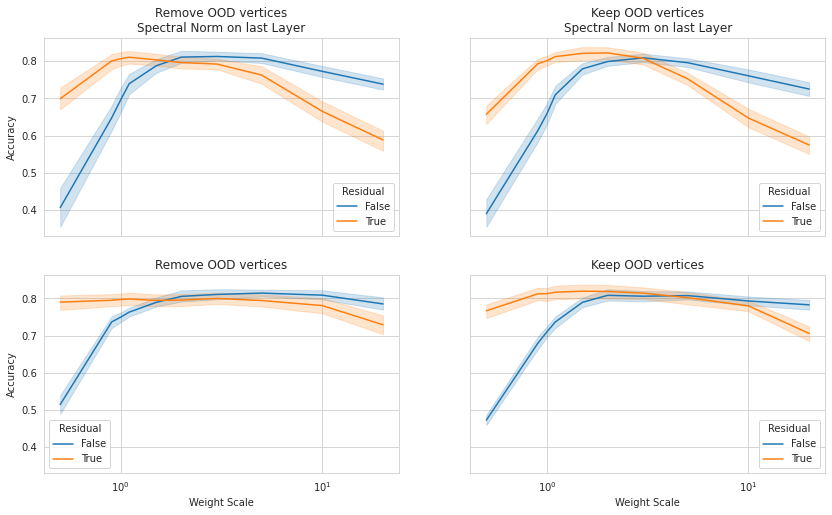

In [5]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for col, norm_out in enumerate((True, False)):
        res = sns.lineplot(data=df[
            (df['Normalize Output'] == norm_out) & (df['Remove OOD'] == remove_ood)
        ], x='Weight Scale', y='Accuracy', hue=('Residual'), ax=axs[col, row])
        label = [
            'Remove OOD vertices' if remove_ood else 'Keep OOD vertices',
        ]
        if norm_out:
            label.append( 'Spectral Norm on last Layer' )
            
        axs[col, row].set_title('\n'.join(label))
        
res.set(xscale='log')


#ax.set_xscale('log')


[None]

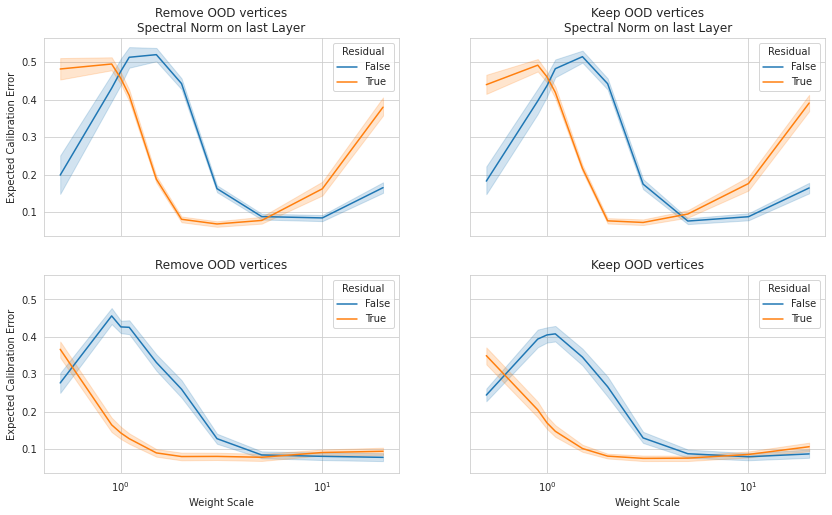

In [6]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for col, norm_out in enumerate((True, False)):
        res = sns.lineplot(data=df[
            (df['Normalize Output'] == norm_out) & (df['Remove OOD'] == remove_ood)
        ], x='Weight Scale', y='Expected Calibration Error', hue=('Residual'), ax=axs[col, row])
        label = [
            'Remove OOD vertices' if remove_ood else 'Keep OOD vertices',
        ]
        if norm_out:
            label.append( 'Spectral Norm on last Layer' )
            
        axs[col, row].set_title('\n'.join(label))
        
res.set(xscale='log')

[None]

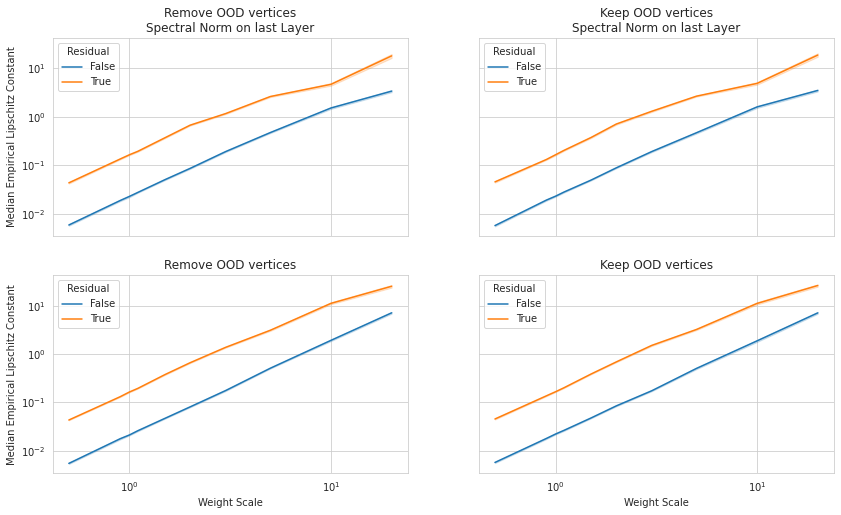

In [7]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for col, norm_out in enumerate((True, False)):
        res = sns.lineplot(data=df[
            (df['Normalize Output'] == norm_out) & (df['Remove OOD'] == remove_ood)
        ], x='Weight Scale', y='Median Empirical Lipschitz Constant', hue=('Residual'), ax=axs[col, row])
        label = [
            'Remove OOD vertices' if remove_ood else 'Keep OOD vertices',
        ]
        if norm_out:
            label.append( 'Spectral Norm on last Layer' )
            
        axs[col, row].set_title('\n'.join(label))
        
res.set(xscale='log')
res.set(yscale='log')


[None]

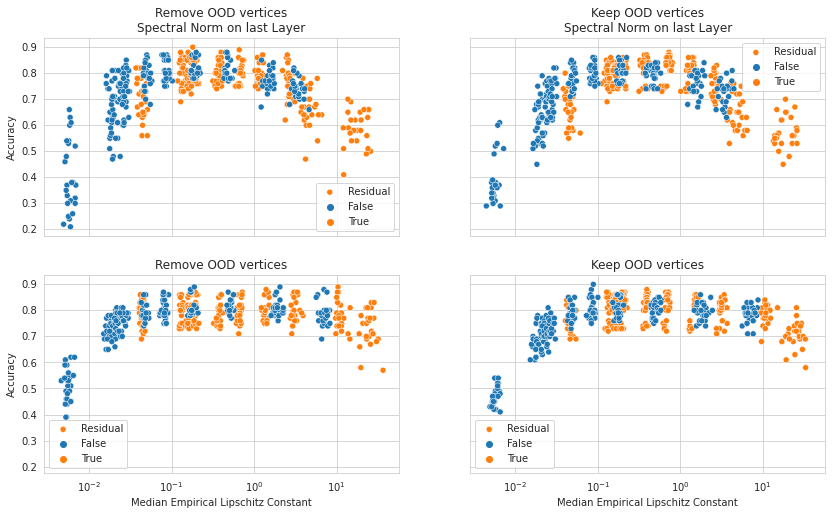

In [8]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for col, norm_out in enumerate((True, False)):
        df_reduced = df[
            (df['Normalize Output'] == norm_out) & (df['Remove OOD'] == remove_ood)
        ]
        x = 'Median Empirical Lipschitz Constant'
        res = sns.scatterplot(data=df_reduced, 
                              x=x, 
                              y='Accuracy', 
                              label='Residual', 
                              hue='Residual', 
                              ax=axs[col, row]
                             )
        
        
        label = [
            'Remove OOD vertices' if remove_ood else 'Keep OOD vertices',
        ]
        if norm_out:
            label.append( 'Spectral Norm on last Layer' )
            
        axs[col, row].set_title('\n'.join(label))
        axs[col, row].legend()
        
res.set(xscale='log')

## Correlation of Accuarcy and Calibration with Lipschitz Constant

[None]

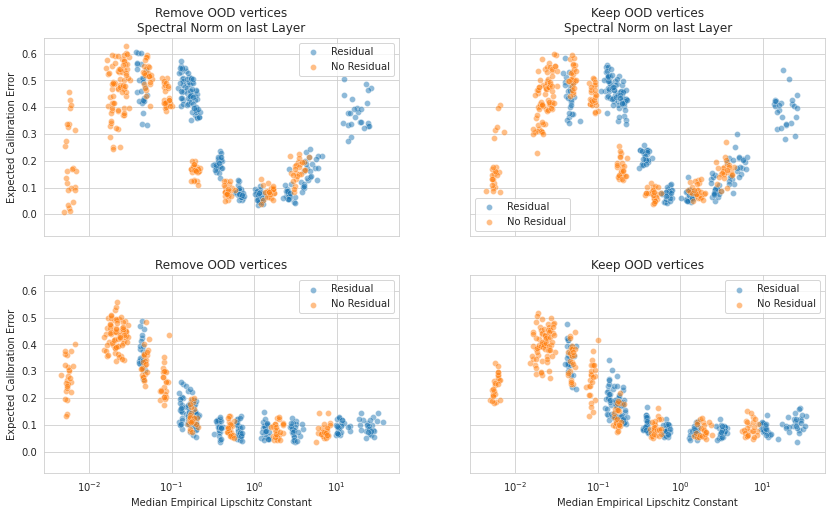

In [9]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for col, norm_out in enumerate((True, False)):
        
        
        res = sns.scatterplot(data=df[
            (df['Normalize Output'] == norm_out) & (df['Remove OOD'] == remove_ood) & (df['Residual'] == True)
        ], x='Median Empirical Lipschitz Constant', y='Expected Calibration Error', label='Residual', 
                          ax=axs[col, row], alpha=0.5)
        res = sns.scatterplot(data=df[
            (df['Normalize Output'] == norm_out) & (df['Remove OOD'] == remove_ood) & (df['Residual'] == False)
        ], x='Median Empirical Lipschitz Constant', y='Expected Calibration Error', label='No Residual', 
                          ax=axs[col, row], alpha=0.5)
        label = [
            'Remove OOD vertices' if remove_ood else 'Keep OOD vertices',
        ]
        if norm_out:
            label.append( 'Spectral Norm on last Layer' )
            
        axs[col, row].set_title('\n'.join(label))
        axs[col, row].legend()
        axs[col, row].set_ylim(bottom=-0.08)

        
res.set(xscale='log')

## Effect of Lipschitz Constant on OOD-Detection

### Effect Lipschitz Constant on AUC-ROC Leave Out Classes (LoC, Bernoulli, Normal)

[None]

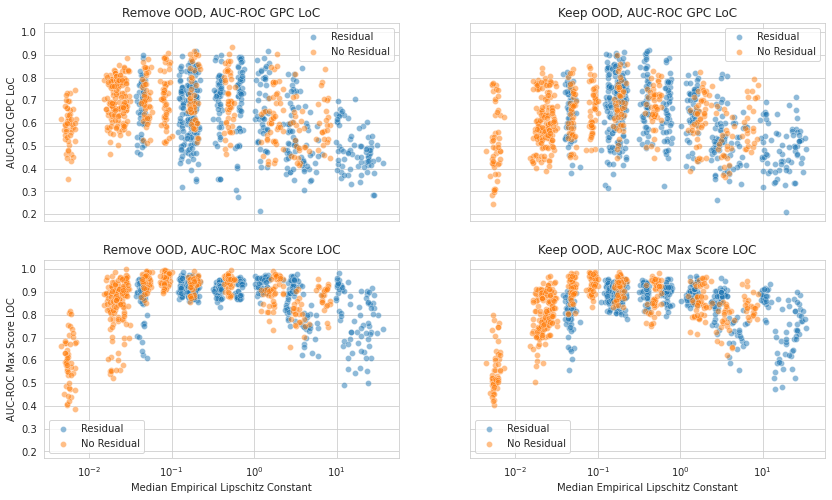

In [10]:


sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for idx, y in enumerate(('AUC-ROC GPC LoC', 'AUC-ROC Max Score LOC')):
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == True)
        ], label='Residual', x='Median Empirical Lipschitz Constant', y=y, ax=axs[idx, row], alpha=0.5)
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == False)
        ], label='No Residual', x='Median Empirical Lipschitz Constant', y=y, ax=axs[idx, row], alpha=0.5)
        label = [
            'Remove OOD' if remove_ood else 'Keep OOD',
            y
        ]
        axs[idx, row].set_title(', '.join(label))
        axs[idx, row].legend()
res.set(xscale='log')

[None]

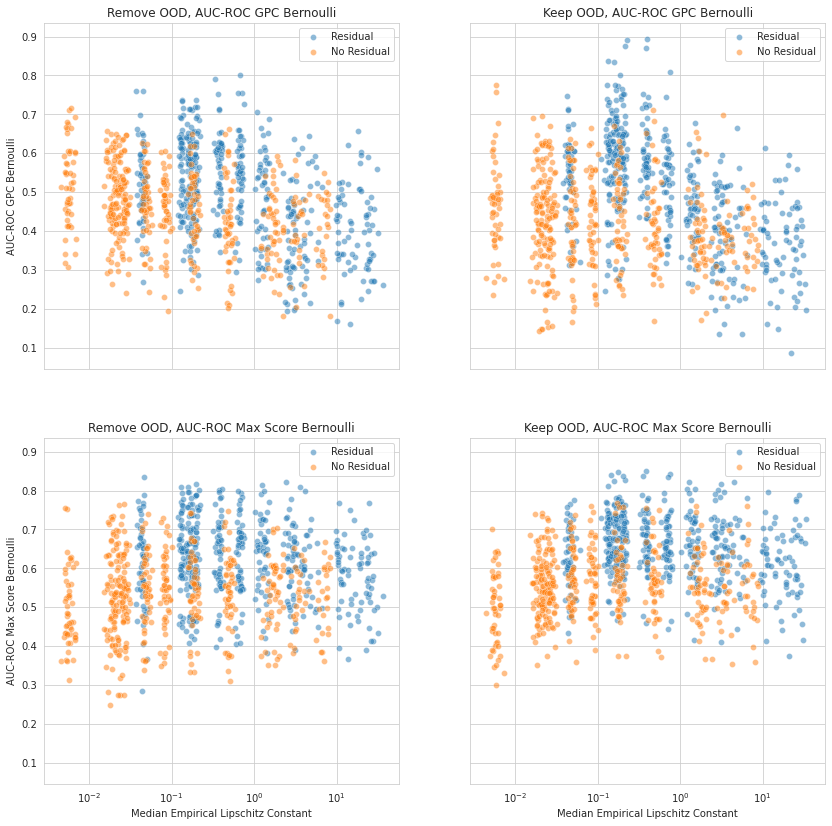

In [11]:


sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for idx, y in enumerate(('AUC-ROC GPC Bernoulli', 'AUC-ROC Max Score Bernoulli')):
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == True)
        ], label='Residual', x='Median Empirical Lipschitz Constant', y=y, ax=axs[idx, row], alpha=0.5)
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == False)
        ], label='No Residual', x='Median Empirical Lipschitz Constant', y=y, ax=axs[idx, row], alpha=0.5)
        label = [
            'Remove OOD' if remove_ood else 'Keep OOD',
            y
        ]
        axs[idx, row].set_title(', '.join(label))
        axs[idx, row].legend()
res.set(xscale='log')

[None]

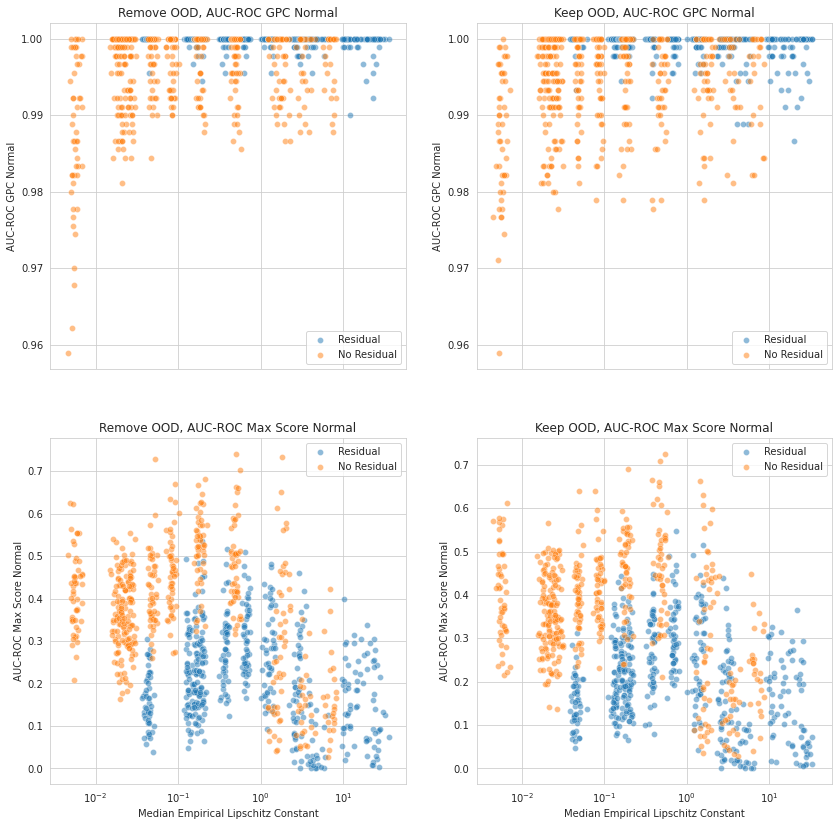

In [12]:


sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=False)
for row, remove_ood in enumerate((True, False)):
    for idx, y in enumerate(('AUC-ROC GPC Normal', 'AUC-ROC Max Score Normal')):
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == True)
        ], label='Residual', x='Median Empirical Lipschitz Constant', y=y, ax=axs[idx, row], alpha=0.5)
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == False)
        ], label='No Residual', x='Median Empirical Lipschitz Constant', y=y, ax=axs[idx, row], alpha=0.5)
        label = [
            'Remove OOD' if remove_ood else 'Keep OOD',
            y
        ]
        axs[idx, row].set_title(', '.join(label))
        axs[idx, row].legend()
res.set(xscale='log')

### Importance of accuracy for AUC-ROC LoC

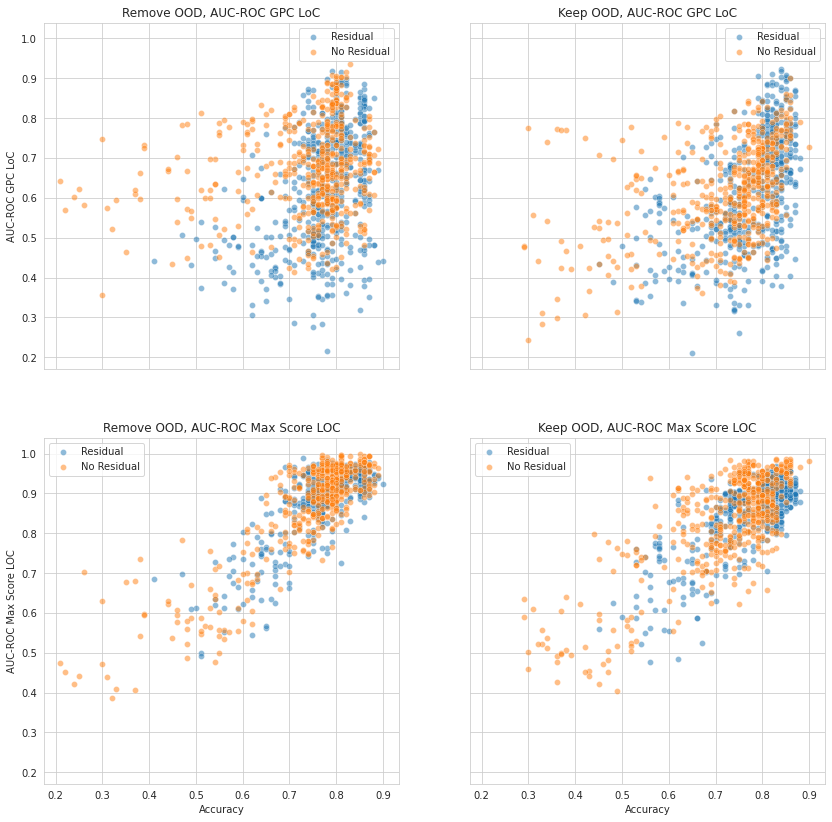

In [13]:


sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for idx, y in enumerate(('AUC-ROC GPC LoC', 'AUC-ROC Max Score LOC')):
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == True)
        ], label='Residual', x='Accuracy', y=y, ax=axs[idx, row], alpha=0.5)
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == False)
        ], label='No Residual', x='Accuracy', y=y, ax=axs[idx, row], alpha=0.5)
        label = [
            'Remove OOD' if remove_ood else 'Keep OOD',
            y
        ]
        axs[idx, row].set_title(', '.join(label))
        axs[idx, row].legend()
#res.set(xscale='log')

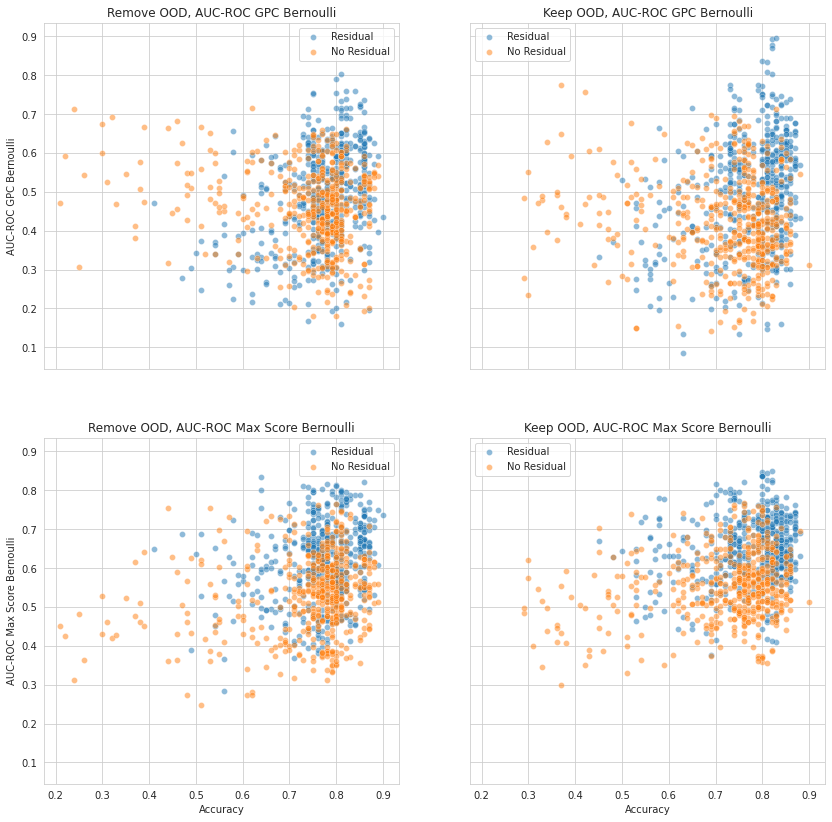

In [14]:


sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
for row, remove_ood in enumerate((True, False)):
    for idx, y in enumerate(('AUC-ROC GPC Bernoulli', 'AUC-ROC Max Score Bernoulli')):
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == True)
        ], label='Residual', x='Accuracy', y=y, ax=axs[idx, row], alpha=0.5)
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == False)
        ], label='No Residual', x='Accuracy', y=y, ax=axs[idx, row], alpha=0.5)
        label = [
            'Remove OOD' if remove_ood else 'Keep OOD',
            y
        ]
        axs[idx, row].set_title(', '.join(label))
        axs[idx, row].legend()
#res.set(xscale='log')

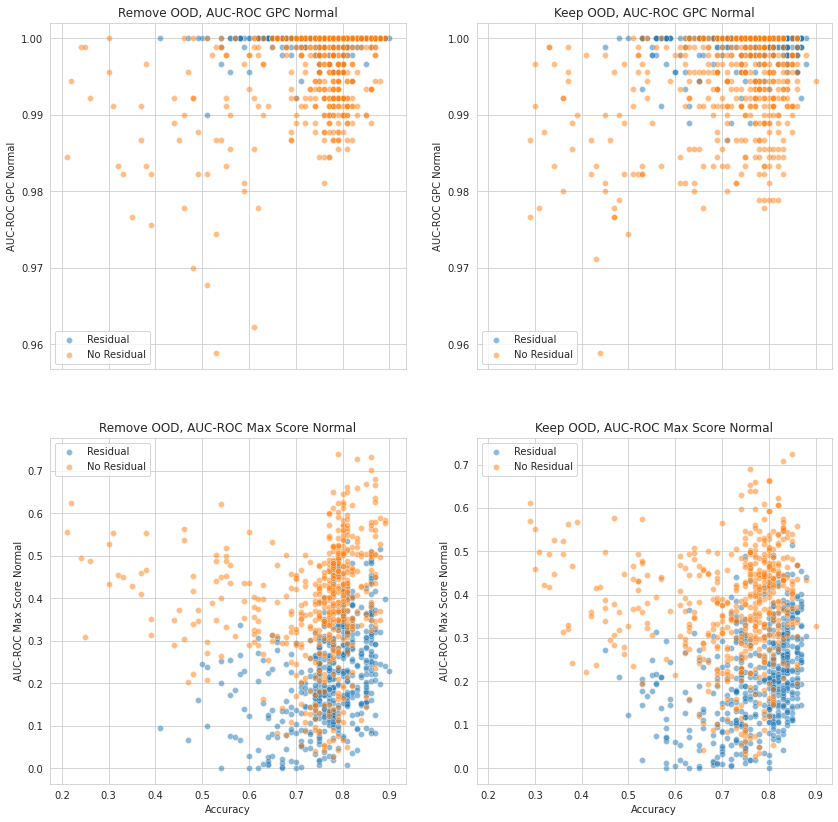

In [16]:


sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=False)
for row, remove_ood in enumerate((True, False)):
    for idx, y in enumerate(('AUC-ROC GPC Normal', 'AUC-ROC Max Score Normal')):
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == True)
        ], label='Residual', x='Accuracy', y=y, ax=axs[idx, row], alpha=0.5)
        res = sns.scatterplot(data=df[
            (df['Remove OOD'] == remove_ood) & (df['Residual'] == False)
        ], label='No Residual', x='Accuracy', y=y, ax=axs[idx, row], alpha=0.5)
        label = [
            'Remove OOD' if remove_ood else 'Keep OOD',
            y
        ]
        axs[idx, row].set_title(', '.join(label))
        axs[idx, row].legend()
#res.set(xscale='log')